## MegaMart Customer Segmentation Analysis


- Diego Colin Reyes A01666354
- Daniel Alejandro López Martínez A01770442
- Eduardo Ramírez Almanza A01660118

In [2]:
import pandas as pd
import numpy as np
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import plotly.subplots as sp
from plotly.offline import init_notebook_mode
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster,cophenet
import matplotlib.pyplot as plt
from scipy.spatial.distance import pdist


# Load the dataset
df = pd.read_csv('retail_customer_data.csv')

In [3]:
df.shape

(3000, 10)

In [4]:
df.head()

,customer_id,monthly_transactions,avg_basket_size,total_spend,avg_session_duration,email_open_rate,product_views_per_visit,return_rate,customer_tenure_months,recency_days
0,CUST_0001,1.8,3.0,527.04,38.1,0.95,17.3,0.00,23,33
1,CUST_0002,5.4,4.5,1137.72,20.0,0.00,16.1,0.41,1,8
2,CUST_0003,2.9,4.4,670.28,64.3,0.52,36.9,0.11,32,39
3,CUST_0004,12.0,22.8,6359.35,37.9,0.17,42.2,0.00,21,5
4,CUST_0005,2.2,17.6,4058.48,22.5,0.53,18.4,0.15,20,18


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 10 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   customer_id              3000 non-null   object 
 1   monthly_transactions     3000 non-null   float64
 2   avg_basket_size          3000 non-null   float64
 3   total_spend              3000 non-null   float64
 4   avg_session_duration     3000 non-null   float64
 5   email_open_rate          3000 non-null   float64
 6   product_views_per_visit  3000 non-null   float64
 7   return_rate              3000 non-null   float64
 8   customer_tenure_months   3000 non-null   int64  
 9   recency_days             3000 non-null   int64  
dtypes: float64(7), int64(2), object(1)
memory usage: 234.5+ KB


In [6]:
df.describe()

,monthly_transactions,avg_basket_size,total_spend,avg_session_duration,email_open_rate,product_views_per_visit,return_rate,customer_tenure_months,recency_days
count,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000
mean,6.011300,9.485133,2367.375387,38.441533,0.443720,31.359467,0.185890,17.912667,20.680667
std,4.776564,7.961280,2248.271454,14.334159,0.427384,9.964088,0.162283,11.242294,12.055419
min,0.200000,1.000000,50.000000,3.400000,0.000000,3.000000,0.000000,1.000000,1.000000
25%,2.100000,3.300000,511.115000,27.000000,0.000000,24.900000,0.040000,9.000000,11.000000
50%,5.000000,5.600000,1456.105000,36.550000,0.340000,31.600000,0.150000,18.000000,18.000000
75%,8.800000,17.325000,3772.227500,49.400000,0.950000,37.800000,0.290000,26.000000,29.250000
max,22.300000,31.600000,8746.290000,87.300000,0.950000,62.400000,0.500000,59.000000,67.000000


In [7]:
missing_summary = df.isnull().sum()
missing_summary

customer_id                0
monthly_transactions       0
avg_basket_size            0
total_spend                0
avg_session_duration       0
email_open_rate            0
product_views_per_visit    0
return_rate                0
customer_tenure_months     0
recency_days               0
dtype: int64

Dataset Size: 3,000 customers with 10 variables
Variables Available:
  - `customer_id`
  - `monthly_transactions`
  - `avg_basket_size`
  - `total_spend`
  - `avg_session_duration`
  - `email_open_rate`
  - `product_views_per_visit`
  - `return_rate`
  - `customer_tenure_months`
  - `recency_days`

Data Quality: 
No missing values detected in any column and all 3,000 records are complete

Data Types: 
  - 7 numerical (float64) behavioral variables
  - 2 numerical (int64) variables
  - 1 categorical (object) identifier

## EDA

In [8]:
#histograms for all behavioral variables (excluding customer_id)
behavioral_vars = df.columns.drop('customer_id')

fig = sp.make_subplots(
    rows=3, cols=3,
    subplot_titles=behavioral_vars,
    vertical_spacing=0.08,
    horizontal_spacing=0.05
)

for i, column in enumerate(behavioral_vars):
    row = i // 3 + 1
    col = i % 3 + 1
    
    fig.add_trace(
        go.Histogram(
            x=df[column], 
            name=column, 
            nbinsx=30,
            marker_color='skyblue',
            opacity=0.7
        ),
        row=row, col=col
    )

fig.update_layout(
    height=900,
    title_text="<b>Distribution of Behavioral Variables</b>",
    title_x=0.5,
    showlegend=False,
    template="plotly_white"
)

for i in range(1, 10):
    fig.update_xaxes(title_text="Value", row=(i-1)//3 + 1, col=(i-1)%3 + 1)
    fig.update_yaxes(title_text="Frequency", row=(i-1)//3 + 1, col=(i-1)%3 + 1)

fig.show()

In [9]:
#correlation matrix (excluding customer_id)
corr_matrix = df[behavioral_vars].corr()

fig = go.Figure(data=go.Heatmap(
    z=corr_matrix.values,
    x=corr_matrix.columns,
    y=corr_matrix.columns,
    colorscale='RdBu_r',
    zmin=-1,
    zmax=1,
    hoverongaps=False,
    text=corr_matrix.round(3),
    texttemplate="%{text}",
    textfont={"size": 10}
))

fig.update_layout(
    title="<b>Correlation Matrix Heatmap - Customer Behavioral Variables</b>",
    width=800,
    height=800,
    xaxis_title="Variables",
    yaxis_title="Variables",
    template="plotly_white"
)
fig.show()

In [10]:
#print highly correlated pairs
print("Highly Correlated Variable Pairs (|r| > 0.5):")
high_corr_pairs = []
for i in range(len(corr_matrix.columns)):
    for j in range(i+1, len(corr_matrix.columns)):
        if abs(corr_matrix.iloc[i, j]) > 0.5:
            high_corr_pairs.append((
                corr_matrix.columns[i], 
                corr_matrix.columns[j], 
                corr_matrix.iloc[i, j]
            ))

for var1, var2, corr in sorted(high_corr_pairs, key=lambda x: abs(x[2]), reverse=True):
    print(f"{var1} vs {var2}:{corr:.3f}")

Highly Correlated Variable Pairs (|r| > 0.5):
avg_basket_size vs total_spend:0.941
monthly_transactions vs total_spend:0.764
monthly_transactions vs avg_basket_size:0.691
monthly_transactions vs recency_days:-0.632
total_spend vs recency_days:-0.612
monthly_transactions vs product_views_per_visit:0.601


In [11]:
#box plots for key variables to detect outliers
key_Variables = ['total_spend', 'monthly_transactions', 'avg_basket_size', 'recency_days']

fig = go.Figure()
for var in key_Variables:
    fig.add_trace(go.Box(
        y=df[var], 
        name=var,
        boxpoints='suspectedoutliers',
        marker_color='lightseagreen',
        line_color='darkblue'
    ))

fig.update_layout(
    title="<b>Outlier Detection - Box Plots for Key Variables</b>",
    yaxis_title="Values",
    template="plotly_white",
    height=500,
    showlegend=False
)
fig.show()

In [12]:
#quantitative outlier analysis using IQR method
print("Outlier Analysis (IQR Method):")
for var in key_Variables:
    q1 = df[var].quantile(0.25)
    q3 = df[var].quantile(0.75)
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    outliers = df[(df[var] < lower_bound) | (df[var] > upper_bound)]
    print(f"{var}: {len(outliers)} outliers ({len(outliers)/len(df)*100:.1f}%)")

Outlier Analysis (IQR Method):
total_spend: 2 outliers (0.1%)
monthly_transactions: 18 outliers (0.6%)
avg_basket_size: 0 outliers (0.0%)
recency_days: 3 outliers (0.1%)


In [13]:
#total Spend vs Monthly Transactions
fig1 = px.scatter(
    df, 
    x='monthly_transactions', 
    y='total_spend',
    color='avg_basket_size',
    size='customer_tenure_months',
    hover_data=['recency_days', 'email_open_rate'],
    title="<b>Total Spend vs Monthly Transactions</b><br>Color: Avg Basket Size, Size: Customer Tenure",
    labels={
        'monthly_transactions': 'Monthly Transactions',
        'total_spend': 'Total Spend ($)',
        'avg_basket_size': 'Avg Basket Size'
    },
    color_continuous_scale='viridis'
)

fig1.update_layout(template="plotly_white")
fig1.show()

In [14]:
#recency vs Frequency behavior
fig2 = px.scatter(
    df, 
    x='recency_days', 
    y='monthly_transactions',
    color='total_spend',
    size='avg_basket_size',
    hover_data=['email_open_rate', 'return_rate'],
    title="<b>Recency vs Monthly Transactions</b><br>Color: Total Spend, Size: Avg Basket Size",
    labels={
        'recency_days': 'Recency (Days since last purchase)',
        'monthly_transactions': 'Monthly Transactions',
        'total_spend': 'Total Spend ($)'
    },
    color_continuous_scale='plasma'
)

fig2.update_layout(template="plotly_white")
fig2.show()

In [15]:
#engagement metrics
fig3 = px.scatter(
    df, 
    x='email_open_rate', 
    y='product_views_per_visit',
    color='avg_session_duration',
    size='total_spend',
    hover_data=['return_rate', 'customer_tenure_months'],
    title="<b>Email Engagement vs Product Views</b><br>Color: Session Duration, Size: Total Spend",
    labels={
        'email_open_rate': 'Email Open Rate',
        'product_views_per_visit': 'Product Views per Visit',
        'avg_session_duration': 'Avg Session Duration (min)'
    },
    color_continuous_scale='rainbow'
)
fig3.update_layout(template="plotly_white")
fig3.show()

## Data Preprocessing

In [16]:
missing_summary

customer_id                0
monthly_transactions       0
avg_basket_size            0
total_spend                0
avg_session_duration       0
email_open_rate            0
product_views_per_visit    0
return_rate                0
customer_tenure_months     0
recency_days               0
dtype: int64

In [17]:
#prepare data for clustering (exclude customer_id)
z = df[behavioral_vars].copy()

print("Original Data Statistics:")
z.head()

Original Data Statistics:


,monthly_transactions,avg_basket_size,total_spend,avg_session_duration,email_open_rate,product_views_per_visit,return_rate,customer_tenure_months,recency_days
0,1.8,3.0,527.04,38.1,0.95,17.3,0.00,23,33
1,5.4,4.5,1137.72,20.0,0.00,16.1,0.41,1,8
2,2.9,4.4,670.28,64.3,0.52,36.9,0.11,32,39
3,12.0,22.8,6359.35,37.9,0.17,42.2,0.00,21,5
4,2.2,17.6,4058.48,22.5,0.53,18.4,0.15,20,18


In [18]:
print("Original Data Ranges (Min-Max):")
original_ranges = pd.DataFrame({
    'Variable': z.columns,
    'Min': z.min().values,
    'Max': z.max().values,
    'Range': (z.max() - z.min()).values,
    'Std': z.std().values
})
original_ranges.round(2)

Original Data Ranges (Min-Max):


,Variable,Min,Max,Range,Std
0,monthly_transactions,0.2,22.30,22.10,4.78
1,avg_basket_size,1.0,31.60,30.60,7.96
2,total_spend,50.0,8746.29,8696.29,2248.27
3,avg_session_duration,3.4,87.30,83.90,14.33
4,email_open_rate,0.0,0.95,0.95,0.43
5,product_views_per_visit,3.0,62.40,59.40,9.96
6,return_rate,0.0,0.50,0.50,0.16
7,customer_tenure_months,1.0,59.00,58.00,11.24
8,recency_days,1.0,67.00,66.00,12.06


In [19]:
scaler = StandardScaler()
z_scaled = scaler.fit_transform(z)

X_scaled_df = pd.DataFrame(z_scaled, columns=z.columns, index=z.index)

print("Standardized Data Statistics:")
X_scaled_df.head().round(3)

Standardized Data Statistics:


,monthly_transactions,avg_basket_size,total_spend,avg_session_duration,email_open_rate,product_views_per_visit,return_rate,customer_tenure_months,recency_days
0,-0.882,-0.815,-0.819,-0.024,1.185,-1.411,-1.146,0.453,1.022
1,-0.128,-0.626,-0.547,-1.287,-1.038,-1.532,1.381,-1.505,-1.052
2,-0.651,-0.639,-0.755,1.804,0.179,0.556,-0.468,1.253,1.520
3,1.254,1.673,1.776,-0.038,-0.641,1.088,-1.146,0.275,-1.301
4,-0.798,1.019,0.752,-1.112,0.202,-1.301,-0.221,0.186,-0.222


In [20]:
print("Standardized Data Ranges (Min-Max):")
scaled_ranges = pd.DataFrame({
    'Variable': X_scaled_df.columns,
    'Min': X_scaled_df.min().values,
    'Max': X_scaled_df.max().values,
    'Mean': X_scaled_df.mean().values,
    'Std': X_scaled_df.std().values
})
scaled_ranges.round(3)

Standardized Data Ranges (Min-Max):


,Variable,Min,Max,Mean,Std
0,monthly_transactions,-1.217,3.411,0.0,1.0
1,avg_basket_size,-1.066,2.778,-0.0,1.0
2,total_spend,-1.031,2.838,0.0,1.0
3,avg_session_duration,-2.445,3.409,0.0,1.0
4,email_open_rate,-1.038,1.185,-0.0,1.0
5,product_views_per_visit,-2.847,3.116,0.0,1.0
6,return_rate,-1.146,1.936,-0.0,1.0
7,customer_tenure_months,-1.505,3.655,0.0,1.0
8,recency_days,-1.633,3.843,-0.0,1.0


## Why Standardization is Necessary for Clustering

### The Problem:
Without standardization, variables with larger numerical ranges (like `total_spend` ranging from $50 to $8,746) would dominate the distance calculations in clustering algorithms, while variables with smaller ranges (like `email_open_rate` ranging from 0 to 0.95) would have minimal impact.

### Impact on Our Data:
- **Before**: Variables had vastly different scales and units
- **After**: All variables are on comparable scales, ensuring equal importance in distance calculations

### Why This Matters for Clustering:
1. **Distance-based algorithms** (K-Means, Hierarchical) rely on Euclidean distance
2. **Equal contribution** from all variables in cluster formation
3. **Better cluster quality** and more meaningful customer segments

## Hierarchical Clustering Analysis

In [21]:
#compute linkage matrices for all four methods (deepseek intervention)
linkage_methods = ['single', 'complete', 'average', 'ward']
linkage_matrices = {}

for method in linkage_methods:
    linkage_matrices[method] = linkage(X_scaled_df, method=method)
    print(f"{method.capitalize()} linkage computed, Shape: {linkage_matrices[method].shape}")

linkage_matrices['ward'][:5].round(3)

Single linkage computed, Shape: (2999, 4)
Complete linkage computed, Shape: (2999, 4)
Average linkage computed, Shape: (2999, 4)
Ward linkage computed, Shape: (2999, 4)


array([[6.260e+02, 2.619e+03, 1.130e-01, 2.000e+00],
       [1.010e+02, 1.033e+03, 1.170e-01, 2.000e+00],
       [1.440e+02, 2.059e+03, 1.560e-01, 2.000e+00],
       [9.780e+02, 2.767e+03, 1.630e-01, 2.000e+00],
       [1.367e+03, 2.567e+03, 1.750e-01, 2.000e+00]])

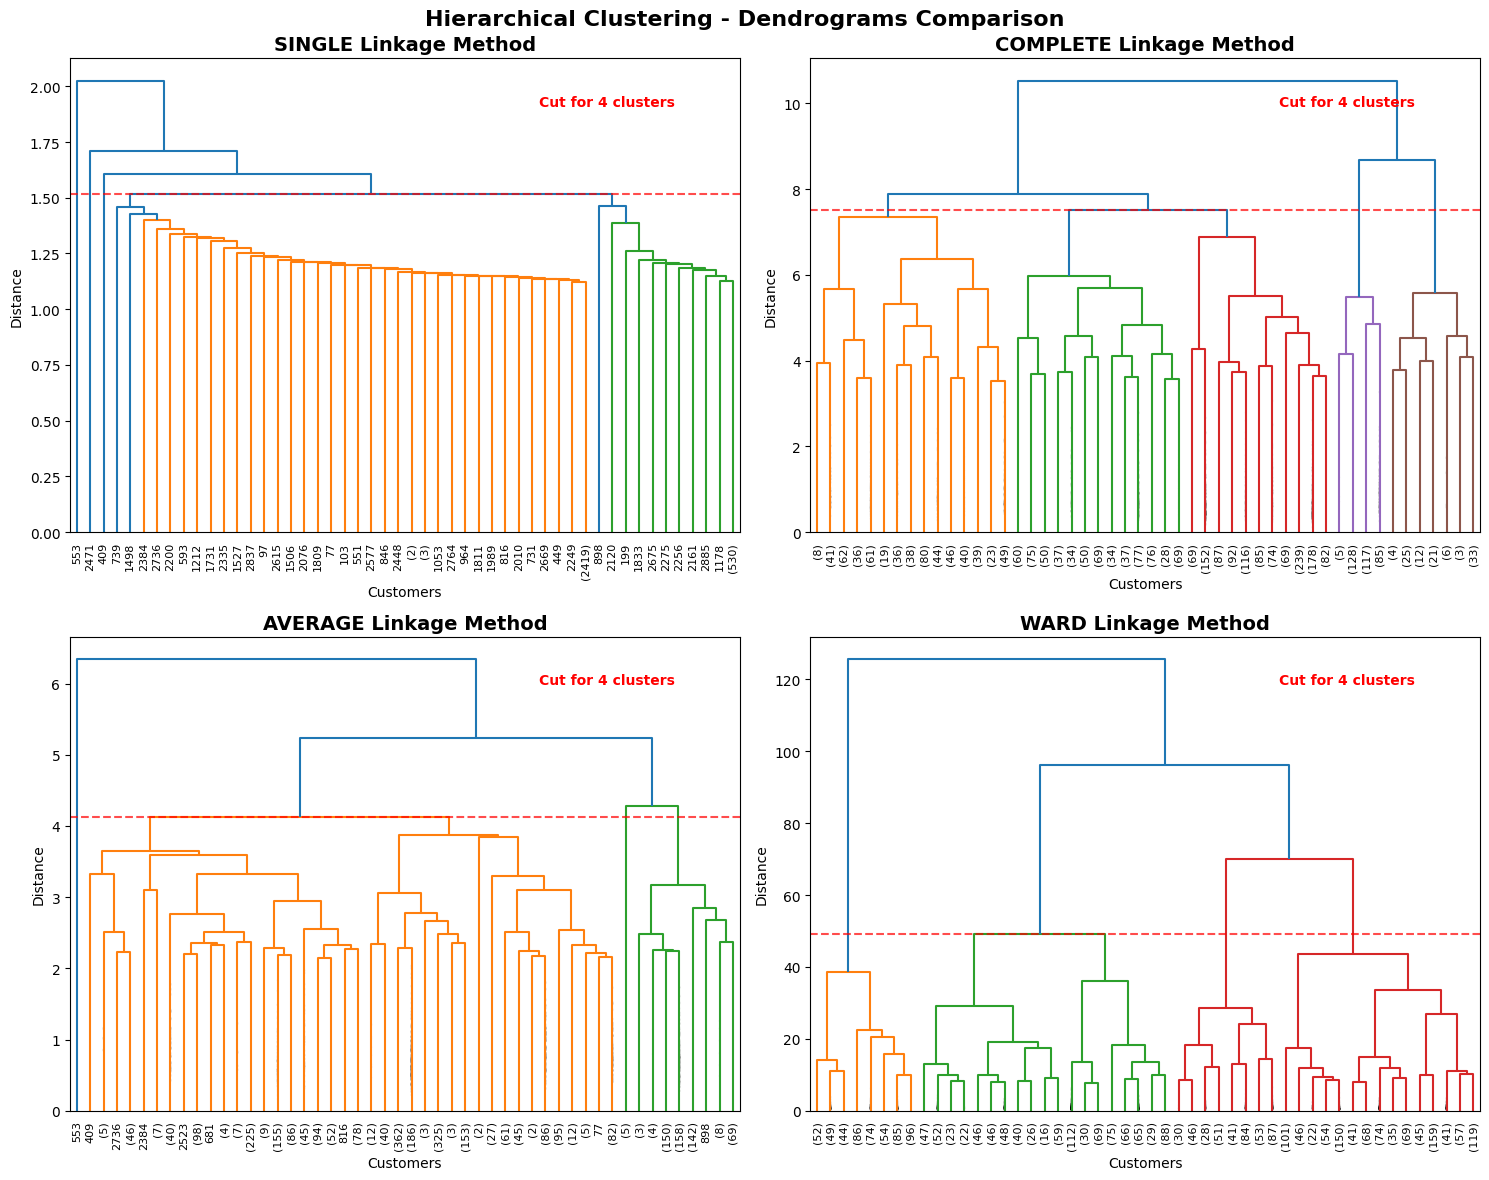

In [22]:
# Create dendrograms for all four linkage methods (deepseek intervention)
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
axes = axes.ravel()

for i, method in enumerate(linkage_methods):
    # Create dendrogram
    dendrogram(
        linkage_matrices[method],
        ax=axes[i],
        truncate_mode='lastp',
        p=50,  # Show last 50 merges for clarity
        show_leaf_counts=True,
        leaf_rotation=90,
        leaf_font_size=8,
        show_contracted=True
    )
    axes[i].set_title(f'{method.upper()} Linkage Method', fontsize=14, fontweight='bold')
    axes[i].set_xlabel('Customers')
    axes[i].set_ylabel('Distance')
    
    # Add horizontal line at potential cut point
    cut_distance = linkage_matrices[method][-4, 2]  # Cut for 4 clusters
    axes[i].axhline(y=cut_distance, color='r', linestyle='--', alpha=0.7)
    axes[i].text(0.7, 0.9, f'Cut for 4 clusters', 
                transform=axes[i].transAxes, color='red', fontweight='bold')

plt.suptitle('Hierarchical Clustering - Dendrograms Comparison', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

## Interpretation of Dendrograms

Comparative Analysis of Linkage Methods


Single Linkage


This method tends to produce elongated, chain-like clusters due to the chaining effect, where points are merged one by one as long as there is a short distance between them. This often leads to poorly separated and less meaningful clusters, making it less suitable for customer segmentation.


Complete Linkage


Focuses on the maximum distance between points of different clusters, produces more compact and well-separated clusters compared to the Single Linkage method, but is sensible to outliers.


Average Linkage


Represents a balance between the Single and Complete methods, uses the average distance between all pairs of points in two clusters, resulting in balanced groupings that are less sensitive to outliers.


Ward Linkage


Minimizes the variance within clusters at each merge. Tends to create compact, spherical, and well-separated clusters, which makes it ideal for customer segmentation and market analysis.
In this case, the Ward method appears to be the most suitable, as it clearly defines four distinct and stable clusters.


Choosing the Cut in the Dendrogram

The cut point is selected where there is a large increase in distance between consecutive merges, this jump indicates that clusters being merged beyond that height are no longer similar, so cutting before it ensures high internal cohesion within each cluster, in the plots, the red dashed line shows the level where **4 clusters** are formed, with Ward’s method showing the cleanest separation.


The Chaining Effect

Occurs when clusters form long chains of sequentially linked points that do not represent true similarity, this effect is **most pronounced in the Single Linkage method**, which makes it less effective for clearly separated groups.

## Optimal number of Clusters (Hierarchical)

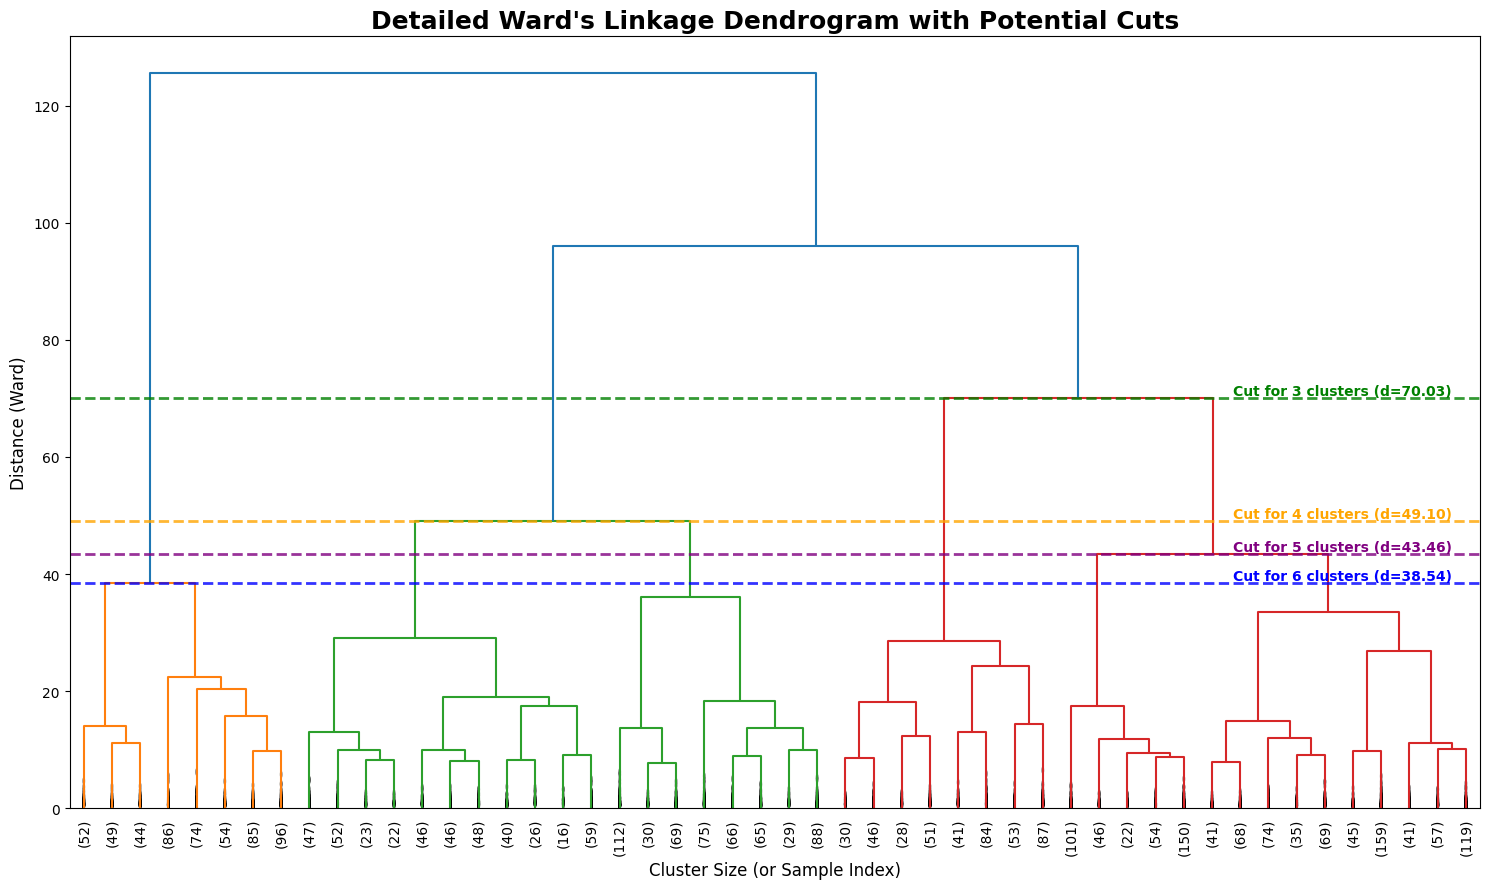

In [23]:
#Gemini was used to increase the quality of the plot

plt.figure(figsize=(15, 9))

ward_matrix = linkage_matrices['ward']

dendrogram(
    ward_matrix,
    truncate_mode='lastp',
    p=50,  # Show last 50 merges
    show_leaf_counts=True,
    leaf_rotation=90,
    leaf_font_size=10,
    show_contracted=True
)

plt.title("Detailed Ward's Linkage Dendrogram with Potential Cuts", fontsize=18, fontweight='bold')
plt.xlabel('Cluster Size (or Sample Index)', fontsize=12)
plt.ylabel('Distance (Ward)', fontsize=12)


# Define the number of clusters (k) and corresponding colors
cuts = {
    3: 'green',
    4: 'orange',
    5: 'purple',
    6: 'blue'
}

xmin, xmax = plt.xlim()

for k, color in cuts.items():
    # Get the distance for the merge that creates k clusters
    cut_distance = ward_matrix[-k, 2]
    
    # Draw the horizontal line using plt.axhline()
    plt.axhline(
        y=cut_distance,
        color=color,
        linestyle='--',
        alpha=0.8,
        linewidth=2
    )
    
    # Add a text label for the cut using plt.text()
    plt.text(
        xmax * 0.98,  # Position text near the right edge
        cut_distance, # Position text at the same y-level as the line
        f'Cut for {k} clusters (d={cut_distance:.2f})',
        color=color,
        fontweight='bold',
        ha='right',   # Align text to the right
        va='bottom'   # Align text just above the line
    )

plt.tight_layout()
plt.show()

In [24]:
#Extracting clusters for k = {3, 4, 5, 6}
k_vals = list(cuts.keys())

clusters = {}

for k in k_vals:
    assignment = fcluster(ward_matrix, t = k, criterion='maxclust') #Maxclust ensures the k number of clusters
    clusters[k] = assignment

In [25]:
#Calculating silhouette scores

silhouette_scores = []


for k in k_vals:
    labels = clusters[k]
    score = silhouette_score(X_scaled_df, labels)
    silhouette_scores.append({'silhouette_score': score})

summary_scores = pd.DataFrame(silhouette_scores, index=k_vals)

summary_scores

,silhouette_score
3,0.294781
4,0.315700
5,0.300267
6,0.247512


Given the unsupervised nature of this task, predefined class labels for customer categorization are not available. Therefore, the silhouette score was employed as the validation metric to determine the optimal number of clusters ($k$).

The analysis revealed that the peak silhouette score was $0.31$, achieved with $k = 4$ clusters. While this score indicates a reasonable partitioning of the data, it also suggests a relatively weak cluster structure. A score in this range implies that the clusters are not sharply delineated and likely exhibit some degree of overlap, meaning the separation between groups is not entirely distinct.

## K-Means Clustering - Elbow method

In [26]:
# Calculating intertia and silhouette score for each K in k means

k_values = [i for i in range(2, 11)]
inertias = []
silhouette_scores_kmeans = []

for k in k_values:
    k_means = KMeans(n_clusters=k, random_state=42, n_init='auto')
    cluster_labels = k_means.fit_predict(X_scaled_df)
    inertias.append(k_means.inertia_)
    #print(k_means.labels_)
    silhouette_scores_kmeans.append({'silhouette_score': silhouette_score(X_scaled_df, cluster_labels)})

summary_scores_kmeans = pd.DataFrame(silhouette_scores_kmeans, index=k_values)

In [27]:
# Plot of itertia vs k (gemini increased presentation of the plot)

fig = go.Figure()

# Add the main trace (the line and markers)
fig.add_trace(go.Scatter(
    x=k_values,
    y=inertias,
    mode='lines+markers',  # Show both the line connecting points and the markers
    name='Inertia',
    marker=dict(color='blue', size=10, line=dict(width=1, color='DarkSlateGrey')),
    line=dict(color='blue', width=2)
))

# Update the layout to add titles and improve aesthetics
fig.update_layout(
    title=dict(
        text='<b>Elbow Method for Optimal k</b>',
        x=0.5, # Center the title
        font=dict(size=24, color='black')
    ),
    xaxis_title=dict(
        text='<b>Number of Clusters (k)</b>',
        font=dict(size=18, color='black')
    ),
    yaxis_title=dict(
        text='<b>Inertia (WCSS)</b>',
        font=dict(size=18, color='black')
    ),
    xaxis=dict(
        dtick=1,  # Ensure we have a tick for every k-value
        gridcolor='rgba(200, 200, 200, 0.5)', # Light grid lines
        zeroline=False,
        showline=True,  
        linewidth=1,  
        linecolor='black'  
    ),
    yaxis=dict(
        gridcolor='rgba(200, 200, 200, 0.5)',
        zeroline=False,
        showline=True, 
        linewidth=1, 
        linecolor='black' 
    ),
    plot_bgcolor='white',  # Set a clean white background
    paper_bgcolor='white',
    hovermode='x unified'  # A nice hover effect
)

fig.show()

In [28]:
# Showing the silhouette scores for K Means
summary_scores_kmeans

,silhouette_score
2,0.344552
3,0.297391
4,0.317311
5,0.269579
6,0.261739
7,0.268698
8,0.279358
9,0.272323
10,0.273340


In [29]:
#Gemini created the subplots

# We give each subplot a title
fig = make_subplots(
    rows=1, cols=2,
    subplot_titles=('<b>Elbow Method (Inertia)</b>', '<b>Silhouette Scores</b>')
)

# 2. Add the Elbow Plot (Inertia) to col 1
fig.add_trace(go.Scatter(
    x=k_values,
    y=inertias,
    mode='lines+markers',
    name='Inertia (WCSS)',
    marker=dict(color='blue', size=10, line=dict(width=1, color='DarkSlateGrey')),
    line=dict(color='blue', width=2)
), row=1, col=1) # Specify row 1, col 1

# 3. Add the Silhouette Score Plot to col 2
fig.add_trace(go.Scatter(
    x=summary_scores_kmeans.index,
    y=summary_scores_kmeans['silhouette_score'],
    mode='lines+markers',
    name='Silhouette Score',
    marker=dict(color='green', size=10, line=dict(width=1, color='DarkSlateGrey')),
    line=dict(color='green', width=2)
), row=1, col=2) # Specify row 1, col 2

# 4. Update the layout for the entire figure
fig.update_layout(
    title=dict(
        text='<b>K-Means Clustering Analysis</b>', # Main title
        x=0.5, # Center the main title
        font=dict(size=24, color='black')
    ),
    plot_bgcolor='white',
    paper_bgcolor='white',
    showlegend=False, # The subplot titles are clear enough
    hovermode='x unified'
)

# 5. Update axes for Subplot 1 (Elbow)
# We use update_xaxes/update_yaxes and specify the col
fig.update_xaxes(
    title_text='<b>Number of Clusters (k)</b>',
    dtick=1, # Tick for every k-value
    gridcolor='rgba(200, 200, 200, 0.5)',
    zeroline=False,
    showline=True,
    linewidth=1,
    linecolor='black',
    row=1, col=1 # Specify which axis to update
)
fig.update_yaxes(
    title_text='<b>Inertia (WCSS)</b>',
    gridcolor='rgba(200, 200, 200, 0.5)',
    zeroline=False,
    showline=True,
    linewidth=1,
    linecolor='black',
    row=1, col=1 # Specify which axis to update
)

# 6. Update axes for Subplot 2 (Silhouette)
fig.update_xaxes(
    title_text='<b>Number of Clusters (k)</b>',
    dtick=1,
    gridcolor='rgba(200, 200, 200, 0.5)',
    zeroline=False,
    showline=True,
    linewidth=1,
    linecolor='black',
    row=1, col=2 # Specify which axis to update
)
fig.update_yaxes(
    title_text='<b>Silhouette Score</b>',
    gridcolor='rgba(200, 200, 200, 0.5)',
    zeroline=False,
    showline=True,
    linewidth=1,
    linecolor='black',
    row=1, col=2 # Specify which axis to update
)

# Show the final combined figure
fig.show()

Analysis of the elbow method plot indicates the "elbow," or the point of diminishing returns, is located between $k=4$ and $k=5$. At this juncture, the rate of decrease in inertia (within-cluster sum of squares) significantly decelerates, and the slope of the curve begins to flatten.

The silhouette score analysis does not perfectly align with this finding, as the global maximum score is observed at $k=2$. However, the score at $k=4$ represents the second-highest peak (a strong local maximum), thereby providing support for $k=4$ as a viable option.

## Final Cluster Selection

the optimal and most justifiable number of clusters is <b>4</b>, this by the following reasons:

1. Dendrogram Structure (Ward method)
- In the "Detailed Ward's Linkage Dendrogram," we look for the largest vertical distance we can "cut" that represents the greatest dissimilarity between merged clusters.

- While the single largest jump is arguably the final one (separating the data into 2 clusters) or the jump above the green line (separating into 3 clusters at d=70.03), the next most significant jump is cut by the orange line (d=49.10).

- This cut at d=49.10 creates 4 distinct clusters. The vertical distance between this cut and the 3-cluster merge (d=70.03) is substantial, indicating that merging these four clusters into three results in a significant loss of information (i.e., we combine two groups that are quite dissimilar). The merges below the 4-cluster line happen at much smaller distances, suggesting higher similarity within those four groups.

2. Elbow Plot Inflection Point
- The "Elbow Method (Inertia)" plot for K-Means helps identify the point of diminishing returns, where adding more clusters does not significantly reduce the within-cluster sum of squares (WCSS).

- The plot shows a sharp "bend" or "elbow" at k=4. The inertia drops sharply from k=2 to 3, and again from k=3 to 4.

- After k=4, the slope of the line flattens considerably. This indicates that the reduction in inertia gained by moving from 4 to 5 clusters (or more) is minimal and not worth the added complexity.

3. Silhouette Scores
- This is the strongest piece of evidence, as the results are consistent across both clustering methods. The silhouette score measures how similar an object is to its own cluster compared to other clusters (higher is better).

- Ward's Linkage Scores: The silhouette score peaks at k=4 (0.3157). This is higher than the score for k=3 (0.2948) and k=5 (0.3003). The score drops significantly at k=6, indicating it is a poor choice.

- K-Means Scores: Ignoring the k=2 solution (which is often too general), the highest and most practical silhouette score is at k=4 (0.3173). After this peak, the score drops notably to 0.2696 for k=5, showing that 4 clusters provide the most distinct and well-separated grouping.


4. Business Considerations (Synthesis)
- For MegaMart, choosing 4 clusters provides the best strategic balance between generalization and actionability. The goal is to create distinct customer segments for targeted marketing, and the variables provided (mixing purchase value, loyalty, and digital engagement) allow for this.
- Avoids Overgeneralization (k=2 or k=3): A 3-cluster solution would likely be too simple, for example, just "Low, Medium, High Value" based on total_spend. This is overgeneralized because it would incorrectly lump strategically different customers together.
- Avoids Non-Actionable Complexity (k=5+): Both the silhouette scores and the elbow plot show that solutions with 5 or more clusters are "forced" and not statistically distinct. For a business, this translates to non-actionable segments.

## Final K-Means Model

In [30]:
selected_k = 4

k_means_model = KMeans(n_clusters=selected_k, random_state=42, n_init='auto')
k_means_model.fit(X_scaled_df)

df_labels = df.copy()
df_labels['label'] = k_means_model.labels_

cluster_counts = df_labels['label'].value_counts().sort_index()
cluster_percentages = df_labels['label'].value_counts(normalize=True).sort_index() * 100

cluster_summary = pd.DataFrame({
    'Cluster': cluster_counts.index,
    'Count': cluster_counts.values,
    'Percentage': cluster_percentages.values
})

print(cluster_summary.to_string())

   Cluster  Count  Percentage
0        0    525   17.500000
1        1    929   30.966667
2        2    433   14.433333
3        3   1113   37.100000


## Cluster Profiling and Interpretation

In [31]:
#Calculating mean for each behavioral variabe grouped by label
cluster_means_original = df_labels.groupby('label')[behavioral_vars].mean()

In [55]:
# Heatmap (improved by Gemini)

scaler = StandardScaler()
scaled_means_for_color = scaler.fit_transform(cluster_means_original)

x_labels = [f'Cluster {i}' for i in cluster_means_original.index]
y_labels = cluster_means_original.columns
scaled_z_data = scaled_means_for_color.T  # Transposed scaled data for color
original_text_data = cluster_means_original.T  # Transposed original data for text

fig = go.Figure()

fig.add_trace(go.Heatmap(
    z=scaled_z_data,                   # Use SCALED data for colors (Z-scores)
    x=x_labels,                        # x-axis: 'Cluster 0', 'Cluster 1', ...
    y=y_labels,                        # y-axis: 'total_spend', 'recency_days', ...
    
    text=original_text_data,           # Use ORIGINAL data for text
    texttemplate="%{text:.2f}",        # Format the text (showing original values)
    
    colorscale='RdBu_r',             # Plotly's version of 'coolwarm'
    colorbar_title='Scaled Value (Z-Score)' # Label for the color bar
))

# 5. Update Layout
fig.update_layout(
    title_text='<b>Cluster Profiles (Means from Original Data, Colors Scaled per Variable)</b>',
    title_x = 0.5,
    xaxis_title='Cluster',
    yaxis_title='Variable',
    # Ensure all variable names are visible
    yaxis={'tickmode': 'array', 'tickvals': y_labels, 'ticktext': y_labels},
    height=600 # Adjust as needed
)

fig.show()

In [40]:
behavioral_vars = list(behavioral_vars)
labels = sorted(list(df_labels['label'].unique()))

In [54]:
#Gemini helped in the creation of this plot

N_ROWS = len(labels)
N_COLS = len(behavioral_vars)

# Create the figure with subplots
# We set column_titles to be the variable names
# We will add row titles manually as annotations on the right side
fig = make_subplots(
    rows=N_ROWS,
    cols=N_COLS,
    column_titles=list(behavioral_vars), # <-- FIX: Convert to list
    # row_titles=[f"Label {l}" for l in labels], # <-- Removed, will add manually
    shared_xaxes=False # Set to 'all' or True if you want all histograms to share the same x-axis
)

# --- 3. Populate the Grid with Histograms ---

# Loop through each row (label)
# Note: Plotly subplots are 1-indexed, so we use enumerate(..., 1)
for r_idx, label_val in enumerate(labels, 1):
    
    # Filter the DataFrame for the current label
    df_filtered_by_label = df_labels[df_labels['label'] == label_val]
    
    # Loop through each column (variable)
    for c_idx, var_name in enumerate(behavioral_vars, 1):
        
        # Get the specific data series for this cell
        data_series = df_filtered_by_label[var_name]
        
        # Create the histogram trace
        hist_trace = go.Histogram(
            x=data_series,
            name=f"L:{label_val}, V:{var_name}",
            # Set histnorm='probability density' if you want to compare shapes, not counts
            # histnorm='probability density', 
        )
        
        # Add the trace to the correct cell in the grid
        fig.add_trace(hist_trace, row=r_idx, col=c_idx)

# --- 4. Update Layout and Add Row Annotations ---

# --- Create list of annotations for row labels ---

# We must get the existing annotations (which include the column titles)
# and ADD our new row annotations to them.
if fig.layout.annotations:
    existing_annotations = list(fig.layout.annotations)
else:
    existing_annotations = []

row_label_annotations = [] # Renamed this list

# We need to calculate the vertical midpoint for each row
# Get the vertical spacing (default is 0.02 if not specified)
try:
    v_spacing = fig.layout.vertical_spacing
except AttributeError:
    v_spacing = 0.02 # Default spacing
    
if v_spacing is None:
    v_spacing = 0.02

# Total available height for plots (not spacing)
total_plot_height = 1.0 - (v_spacing * (N_ROWS - 1))

# Height of one plot
plot_height = total_plot_height / N_ROWS

# Loop through each row (1-indexed) and create an annotation
for r_idx, label_val in enumerate(labels, 1):
    
    # Calculate y-domain for this row (r_idx is 1-based)
    # Rows are built from top (1.0) to bottom (0.0)
    
    # Top edge of the current row
    y_top = 1.0 - ( (r_idx - 1) * (plot_height + v_spacing) )
    
    # Bottom edge of the current row
    y_bottom = y_top - plot_height
    
    # Midpoint of the row
    y_mid = (y_top + y_bottom) / 2
    
    row_label_annotations.append(
        go.layout.Annotation(
            text=f"<b>Label {label_val}</b>", # Make it bold
            align='right', # Change alignment
            showarrow=False,
            xref='paper',       # Use 'paper' for viewport-relative coordinates
            yref='paper',
            x=-0.05,             # Position slightly to the LEFT of the plot area
            y=y_mid,            # Position at the vertical midpoint of the row
            xanchor='right',     # Anchor text to its right
            yanchor='middle'    # Anchor text to its middle
        )
    )

# Combine the column titles (already in) with our new row labels
all_annotations = existing_annotations + row_label_annotations

# --- Apply layout updates ---
fig.update_layout(
    title_text="<b>Distribution of Behavioral Variables Across Labels</b>",
    height=1000,  # Adjust height as needed
    width=1900,   # Adjust width as needed
    showlegend=False,  # Hide the legend as it would be too cluttered
    bargap=0.05,       # Add a small gap between histogram bars
    annotations=all_annotations, # Add ALL annotations (col titles + row labels)
    margin=dict(l=100), # Add a LEFT margin to make space for the labels
    title_x = 0.5
)

# Show the figure
fig.show()

### Characterization

- **Cluster 0**: This is MegaMart's elite segment, defined by exceptionally high spending, large basket sizes, and frequent monthly transactions. They are also the most digitally engaged (high email open rates, session duration) and loyal, with long tenures and very low recency (they just shopped). Their low return rate makes them the most profitable and stable customer base.

- **Cluster 1**: This is the least profitable group, with the lowest total spending, fewest transactions, and smallest basket sizes. They are defined by negative metrics: they have the highest recency (haven't shopped in a long time) and a very high return rate. Despite spending a long time on the site, they are disengaged (low email open rate) and have low tenure, indicating they are likely to churn.

- **Cluster 2**: This is MegaMart's second-best spending segment, characterized by high total spend and the second-largest average basket size. They seem to be established customers (good tenure) who shop efficiently, as they have the lowest product views and shortest session durations. Their primary drawback is a high return rate, which cuts into their profitability.

- **Cluster 3**: This segment consists of newer customers (low tenure) with modest total spending and small basket sizes. Their defining characteristic is frequency: they have the second-highest number of monthly transactions and low recency, suggesting they are active, casual shoppers. They are moderately engaged online and have a good low return rate, making them a high-potential group to nurture.

## Cluster Validation - Silhouette Analysis